## Приближение взаимной информации в вершине с помощью нейронных сетей
### Лунин Дмитрий, 25.02.2016

При поиске структуры байесовской сети возникает задача поиска набора родителей вершины, который максимизирует общую информацию (возможно, с некоторой регуляризацией). Проблема в том, что для достаточно больших сетей таких наборов может быть очень много. Возможно, в функции общей информации есть скрытые закономерности, которые помогут эффективнее ее оптимизировать. Для их поиска можно использовать нейронные сети.

Здесь с помощью нейронных сетей строится приближение функции информации; при этом получается неплохой результат.

In [1]:
%%capture
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore', module='matplotlib')
warnings.filterwarnings('ignore', module='IPython')

In [4]:
%%capture
import sys
sys.path.append('/home/wrwt/Programming/pygraphmodels')
import graphmodels as gm

Загружаем байесовскую сеть insurance -- в ней достаточно вершин, чтобы задача была нетривиальной, но при этом вычисления не занимают много времени.

In [5]:
dgm = gm.DGM.read('../networks/alarm.bif')

In [8]:
n_nodes = len(dgm.nodes()) # количество вершин
n_nodes

37

In [9]:
from math import factorial
k = 5
# количество вариантов выбора родителей вершины, при условии что их не больше k.
factorial(n_nodes - 1) / factorial(n_nodes - k - 1) / factorial(k)

376992L

In [11]:
dgm.draw()

Генерируем данные из байесовской сети.

In [12]:
data = dgm.rvs(size=100000)

Рассмотрим вершину Antilock

In [13]:
target = 'CATECHOL'
fact = dgm.cpd(target)
fact

INSUFFANESTH,TPR,SAO2,ARTCO2,CATECHOL,Prob.
TRUE,LOW,LOW,LOW,NORMAL,0.010
TRUE,LOW,LOW,LOW,HIGH,0.990
TRUE,LOW,LOW,NORMAL,NORMAL,0.010
TRUE,LOW,LOW,NORMAL,HIGH,0.990
TRUE,LOW,LOW,HIGH,NORMAL,0.010
TRUE,LOW,LOW,HIGH,HIGH,0.990
TRUE,LOW,NORMAL,LOW,NORMAL,0.010
TRUE,LOW,NORMAL,LOW,HIGH,0.990
TRUE,LOW,NORMAL,NORMAL,NORMAL,0.010
TRUE,LOW,NORMAL,NORMAL,HIGH,0.990


In [14]:
def generate_subset(target, factor, kmin=1, kmax=4, size=1):
    """
    Generate `size` random subsets of parents for node `target` with factor `factor` 
    and calculate discrete mutual information for them.
    Number of parents lies between kmin and kmax
    """
    arguments = list(factor.arguments)
    arguments.remove(target)
    arguments = np.asarray(arguments)
    
    n = np.random.randint(low=kmin, high=kmax+1, size=size)
    result = []
    score = []
    for i, cn in enumerate(n):
        current = np.random.choice(arguments, size=cn, replace=False)
        result.append([1.0 if arg in current else 0.0 for arg in arguments])
        score.append(gm.information.discrete_mutual_information(data[[target]], data[current]))
    return np.vstack(result), np.hstack(score)

In [15]:
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['HISTORY', 'CVP', 'PCWP', 'HYPOVOLEMIA', 'LVEDVOLUME', 'LVFAILURE', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HREKG', 'ERRCAUTER', 'HRSAT', 'INSUFFANESTH', 'ANAPHYLAXIS', 'TPR', 'EXPCO2', 'KINKEDTUBE', 'MINVOL', 'FIO2', 'PVSAT', 'SAO2', 'PAP', 'PULMEMBOLUS', 'SHUNT', 'INTUBATION', 'PRESS', 'DISCONNECT', 'MINVOLSET', 'VENTMACH', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'ARTCO2', 'HR', 'CO', 'BP']
36


#### Генерация обучающей выборки для нейросети

In [16]:
X_train, y_train = generate_subset(target, fact, kmin=1, kmax=5, size=1000)

In [18]:
import theano
import theano.tensor as T
from theano.tensor import nnet

n_in = 36
n_hid = 50
n_out = 1

W0 = T.dmatrix('W0')
b0 = T.dvector('b0')
W1 = T.dvector('W1')
b1 = T.dscalar('b1')

X = T.dvector('X')
y = T.dscalar('y')

hidden = nnet.sigmoid(X.dot(W0) + b0)
out = hidden.dot(W1) + b1
loss = T.mean((out - y) ** 2)

deriv = T.concatenate([T.grad(loss, wrt=W0).flatten(),
                      T.grad(loss, wrt=W1).flatten(),
                      T.grad(loss, wrt=b0).flatten(),
                      [T.grad(loss, wrt=b1)]])

predict = theano.function(inputs=[X, W0, b0, W1, b1], outputs=out, name='predict')
loss_deriv = theano.function(inputs=[X, y, W0, b0, W1, b1], outputs=[loss, deriv], name='loss_deriv')

def get_loss_deriv(theta, X, y):
    W0 = theta[:n_in*n_hid].reshape((n_in, n_hid))
    W1 = theta[n_in*n_hid:n_in*n_hid + n_hid*n_out]
    b0 = theta[n_in*n_hid + n_hid*n_out:n_in*n_hid + n_hid*n_out + n_hid]
    b1 = theta[n_in*n_hid + n_hid*n_out + n_hid]
    res1 = []
    res2 = []
    for cx, cy in zip(X, y):
        c1, c2 = loss_deriv(cx, cy, W0, b0, W1, b1)
        res1.append(c1)
        res2.append(c2)
    return np.mean(res1), np.mean(res2, axis=0)

def initialize(size):
    return np.random.rand(size)

def learn(X, y):
    theta = initialize(n_in * n_hid + n_hid * n_out + n_hid + n_out)
    from scipy.optimize import minimize
    res = minimize(lambda theta: get_loss_deriv(theta, X, y), theta, jac=True, method='L-BFGS-B')
    print(res)
    return res['x']

def get_predict(theta, X):
    W0 = theta[:n_in*n_hid].reshape((n_in, n_hid))
    W1 = theta[n_in*n_hid:n_in*n_hid + n_hid*n_out]
    b0 = theta[n_in*n_hid + n_hid*n_out:n_in*n_hid + n_hid*n_out + n_hid]
    b1 = theta[n_in*n_hid + n_hid*n_out + n_hid]
    return np.array([predict(x, W0, b0, W1, b1) for x in X])

/usr/local/lib/python2.7/dist-packages/scipy/optimize/_numdiff.py:8: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from ._group_columns import group_dense, group_sparse
/usr/local/lib/python2.7/dist-packages/scipy/optimize/_numdiff.py:8: RuntimeWarning: numpy.broadcast size changed, may indicate binary incompatibility
  from ._group_columns import group_dense, group_sparse
/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:24: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from . import vonmises_cython
/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:24: RuntimeWarning: numpy.broadcast size changed, may indicate binary incompatibility
  from . import vonmises_cython
/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:188: RuntimeWarning: numpy.flatiter size changed, may indicate binary incompatibility
  from ._rank import tiecorrect
/usr/local/lib/python2.7/dis

In [19]:
theta = learn(X_train, y_train)

      fun: 3.4083403173957943e-05
 hess_inv: <1901x1901 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.21255505e-09,  -8.29792652e-09,   5.21745659e-07, ...,
         4.87679056e-06,  -3.97785866e-06,  -1.92737475e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1083
      nit: 871
   status: 0
  success: True
        x: array([ 0.39687861,  0.37538736,  0.0957484 , ...,  0.48896215,
        0.10658795, -0.50013442])


#### Генерация тестовой выборки

In [20]:
X_test, y_test = generate_subset(target, fact, kmin=4, kmax=5, size=100)

# Некоторые наборы уже были в обучающей выборке, поэтому мы их выбрасываем.
train_set = set(map(tuple, X_train))
idx = [i for i, x in enumerate(X_test) if tuple(x) not in train_set]
X_test = X_test[idx]
y_test = y_test[idx]
print('accepted', len(idx))

('accepted', 100)


In [21]:
# mean absolute error для тестовой выборки
np.mean(np.abs(get_predict(theta, X_test) - y_test))

0.0073894481893979893

Интересно посмотреть, насколько отличаются оптимальный набор найденный по нейронной сети от реального оптимального набора (среди тестовой выборки).

In [22]:
y_test[np.argmax(get_predict(theta, X_test))]

0.22624531161808084

In [23]:
# количество более хороших наборов, чем найденный
np.sum(y_test > y_test[np.argmax(get_predict(theta, X_test))])

0

In [24]:
np.max(y_test)

0.22624531161808084

(array([ 11.,  18.,  15.,   8.,   1.,   3.,   7.,  24.,  12.,   1.]),
 array([ 0.00082913,  0.02337075,  0.04591237,  0.06845399,  0.0909956 ,
         0.11353722,  0.13607884,  0.15862046,  0.18116208,  0.20370369,
         0.22624531]),
 <a list of 10 Patch objects>)

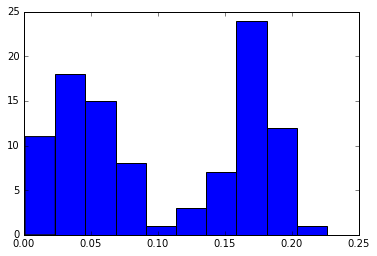

In [25]:
plt.hist(y_test)

Как видим, нейронная сеть находит неплохой набор. Значит, она обучается достаточно хорошему представлению взаимной информации в вершине.

### Baseline
Что если хорошее качество обусловлено тем, что данные в этом примере подчиняются очень простой закономерности и нейронные сети на самом деле не нужны? В этом разделе, попробуем приблизить взаимную информацию для набора родителей суммой взаимных информаций для каждого из них.

In [21]:
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['HISTORY', 'CVP', 'PCWP', 'HYPOVOLEMIA', 'LVEDVOLUME', 'LVFAILURE', 'STROKEVOLUME', 'ERRLOWOUTPUT', 'HRBP', 'HREKG', 'ERRCAUTER', 'HRSAT', 'INSUFFANESTH', 'ANAPHYLAXIS', 'TPR', 'EXPCO2', 'KINKEDTUBE', 'MINVOL', 'FIO2', 'PVSAT', 'SAO2', 'PAP', 'PULMEMBOLUS', 'SHUNT', 'INTUBATION', 'PRESS', 'DISCONNECT', 'MINVOLSET', 'VENTMACH', 'VENTTUBE', 'VENTLUNG', 'VENTALV', 'ARTCO2', 'HR', 'CO', 'BP']
36


In [22]:
mi_array = np.array([gm.information.discrete_mutual_information(data[[target]], data[[current]]) for current in args])
def score(subset):
    return np.dot(subset, mi_array)

In [25]:
X_test, y_test = generate_subset(target, fact, kmin=4, kmax=5, size=100)

In [26]:
scores = score(X_test)

In [27]:
# mean absolute error для тестовой выборки
np.mean(np.abs(scores - y_test))

0.027439896563419122

In [29]:
y_test[np.argmax(scores)]

0.23331121150282649

In [30]:
np.max(y_test)

0.23358598080222245

In [32]:
# количество более хороших наборов, чем найденный
np.sum(y_test > y_test[np.argmax(scores)])

1

Оказывается, что на практике и это можно считать хорошим приближением.

## Noisy XOR

In [114]:
arguments = ['a', 'b', 'a_xor_b']
dgm = gm.DGM()
dgm.add_nodes_from(arguments)
dgm.add_edges_from([('a', 'a_xor_b'), ('b', 'a_xor_b')])
dgm.node['a']['cpd'] = gm.TableFactor(arguments, ['a'])
dgm.node['a']['cpd'].table = np.array([[[0.5]], [[0.5]]])
dgm.node['b']['cpd'] = gm.TableFactor(arguments, ['b'])
dgm.node['b']['cpd'].table = np.array([[[0.5], [0.5]]])
dgm.node['a_xor_b']['cpd'] = gm.TableFactor(arguments, ['a', 'b', 'a_xor_b'])
dgm.node['a_xor_b']['cpd'].table = np.array([[[0.9, 0.1], [0.1, 0.9]], [[0.1, 0.9], [0.9, 0.1]]])
dgm.draw()

In [36]:
data = dgm.rvs(size=10000)

In [39]:
fact = dgm.cpd('a_xor_b')

In [41]:
target = 'a_xor_b'
args = list(fact.arguments)
args.remove(target)
print(args)
print(len(args))

['a', 'b']
2


In [42]:
mi_array = np.array([gm.information.discrete_mutual_information(data[[target]], data[[current]]) for current in args])
def score(subset):
    return np.dot(subset, mi_array)

In [115]:
X_test, y_test = generate_subset(target, fact, kmin=1, kmax=2, size=100)
scores = score(X_test) 

ValueError: shapes (100,36) and (2,) not aligned: 36 (dim 1) != 2 (dim 0)

In [51]:
score([1., 1.])

2.0215778355934795e-05

In [52]:
score([0., 1.])

1.9230883116840144e-05

In [53]:
score([0., 1.])

1.9230883116840144e-05

In [54]:
# mean absolute error для тестовой выборки
np.mean(np.abs(scores - y_test))

0.18513732946194419

In [58]:
X_train, y_train = generate_subset(target, fact, kmin=1, kmax=2, size=10)